In [83]:
# Cell 1 — Colab setup & installs

# Install required packages
!pip install -q torch tqdm sacrebleu nltk sentencepiece rouge-score

# Imports
import os, re, math, random, json, time
from collections import Counter
from typing import List, Tuple
import pandas as pd
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import sacrebleu
import nltk
nltk.download('punkt', quiet=True)

# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)


Device: cuda


In [84]:
# Cell 2 — data path config & folders
# If you mounted Drive and want to use a Drive path, change DATA_PATH accordingly.
DATA_PATH = "/content/final_main_dataset.tsv"   # change if needed
MODEL_DIR = "models"
os.makedirs(MODEL_DIR, exist_ok=True)

# Quick check: ensure file exists
if os.path.exists(DATA_PATH):
    print("Found dataset:", DATA_PATH)
else:
    print("Dataset not found at", DATA_PATH, "- upload it to the notebook environment or change DATA_PATH.")


Found dataset: /content/final_main_dataset.tsv


In [85]:
# Cell 3 — load Common Voice TSV and create (input,response) pairs

def load_urdu_tsv_dataset(path, pair_mode="consecutive", max_pairs=None, verbose=True):
    """
    Load Common Voice style TSV and return list of (input, response) pairs.
    pair_mode:
      - "consecutive": pair sentences [0]->[1], [2]->[3], ...
      - "sliding": pair [i] -> [i+1] for all i
      - "random": pair each sentence with a random sentence
    max_pairs: limit number of pairs (useful for quick experiments)
    """
    df = pd.read_csv(path, sep="\t", encoding="utf-8")
    if "sentence" not in df.columns:
        raise ValueError("Expected a 'sentence' column in the TSV file.")
    sentences = df["sentence"].dropna().astype(str).tolist()
    pairs = []
    if pair_mode == "consecutive":
        for i in range(0, len(sentences) - 1, 2):
            pairs.append((sentences[i], sentences[i+1]))
    elif pair_mode == "sliding":
        for i in range(len(sentences) - 1):
            pairs.append((sentences[i], sentences[i+1]))
    elif pair_mode == "random":
        for i in range(len(sentences)):
            pairs.append((sentences[i], random.choice(sentences)))
    else:
        raise ValueError("Unsupported pair_mode: " + str(pair_mode))
    if max_pairs:
        pairs = pairs[:max_pairs]
    if verbose:
        print(f"Loaded {len(pairs)} pairs (mode={pair_mode}) from {path}")
    return pairs

# Quick preview rows (first 5)
if os.path.exists(DATA_PATH):
    try:
        preview = pd.read_csv(DATA_PATH, sep="\t", encoding="utf-8", nrows=5)
        print("TSV columns:", preview.columns.tolist())
        display(preview.head(5))
    except Exception as e:
        print("Could not preview dataset:", e)


TSV columns: ['client_id', 'path', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accents', 'variant', 'locale', 'segment']


,client_id,path,sentence,up_votes,down_votes,age,gender,accents,variant,locale,segment
0,e53f84d151d6cc6d45a57decde08a99efe47d7751a4ca6...,common_voice_ur_31771683.mp3,کبھی کبھار ہی خیالی پلاو بناتا ہوں,2,0,twenties,male,NaN,NaN,ur,NaN
1,e53f84d151d6cc6d45a57decde08a99efe47d7751a4ca6...,common_voice_ur_31771684.mp3,اور پھر ممکن ہے کہ پاکستان بھی ہو,2,1,twenties,male,NaN,NaN,ur,NaN
2,e53f84d151d6cc6d45a57decde08a99efe47d7751a4ca6...,common_voice_ur_31771685.mp3,یہ فیصلہ بھی گزشتہ دو سال میں,2,0,twenties,male,NaN,NaN,ur,NaN
3,e53f84d151d6cc6d45a57decde08a99efe47d7751a4ca6...,common_voice_ur_31771730.mp3,ان کے بلے بازوں کے سامنے ہو گا,3,0,twenties,male,NaN,NaN,ur,NaN
4,e53f84d151d6cc6d45a57decde08a99efe47d7751a4ca6...,common_voice_ur_31771732.mp3,آبی جانور میں بطخ بگلا اور دُوسْرا آبی پرندہ ش...,3,0,twenties,male,NaN,NaN,ur,NaN


In [86]:
# Cell 4 — Urdu normalization + simple tokenizer
RE_ARABIC_DIACRITICS = re.compile(r"[\u0610-\u061A\u064B-\u065F\u06D6-\u06ED\u08D4-\u08E1]")
NORMALIZATION_MAP = {
    '\u0622': '\u0627',  # آ -> ا
    '\u0623': '\u0627',  # أ -> ا
    '\u0625': '\u0627',  # إ -> ا
    '\u0649': '\u06CC',  # ى -> ی
    '\u0629': '\u0647',  # ة -> ه
}
URDU_PUNCT = r"[\.\,\!\?\:\;\-\—\(\)\"\'،؟]"

def normalize_urdu(text: str) -> str:
    """Normalize Urdu text: remove diacritics and unify common letter variants."""
    if not isinstance(text, str):
        return ""
    t = text.strip()
    t = RE_ARABIC_DIACRITICS.sub("", t)
    t = "".join(NORMALIZATION_MAP.get(ch, ch) for ch in t)
    t = re.sub(r"\s+", " ", t)
    return t

def simple_tokenize(text: str) -> List[str]:
    """A simple tokenizer that spaces punctuation then splits by whitespace."""
    if not isinstance(text, str):
        return []
    text = re.sub(URDU_PUNCT, lambda m: f" {m.group(0)} ", text)
    tokens = text.strip().split()
    return tokens

# Quick demo
print("Normalized:", normalize_urdu("آپ کیسے ہیں؟"))
print("Tokens  :", simple_tokenize("میں ٹھیک ہوں، شکریہ!"))


Normalized: اپ کیسے ہیں؟
Tokens  : ['میں', 'ٹھیک', 'ہوں', '،', 'شکریہ', '!']


In [87]:
# Cell 5 — vocabulary utilities
PAD, SOS, EOS, UNK = "<pad>", "<sos>", "<eos>", "<unk>"

class Vocab:
    def __init__(self, min_freq=1, max_size=None):
        self.min_freq = min_freq
        self.max_size = max_size
        self.freqs = Counter()
        self.token2idx = {}
        self.idx2token = []
        self.built = False

    def add_sentence(self, tokens: List[str]):
        self.freqs.update(tokens)

    def build(self):
        specials = [PAD, SOS, EOS, UNK]
        self.idx2token = list(specials)
        self.token2idx = {t:i for i,t in enumerate(self.idx2token)}
        items = [item for item in self.freqs.items() if item[1] >= self.min_freq]
        items.sort(key=lambda x: -x[1])
        if self.max_size:
            items = items[:self.max_size - len(self.idx2token)]
        for tok, _ in items:
            if tok in self.token2idx:
                continue
            self.token2idx[tok] = len(self.idx2token)
            self.idx2token.append(tok)
        self.built = True

    def encode(self, tokens: List[str]) -> List[int]:
        if not self.built:
            raise RuntimeError("Vocab not built.")
        return [self.token2idx.get(t, self.token2idx[UNK]) for t in tokens]

    def decode(self, ids: List[int], remove_specials=True) -> List[str]:
        toks = [self.idx2token[i] if i < len(self.idx2token) else UNK for i in ids]
        if remove_specials:
            toks = [t for t in toks if t not in {PAD, SOS, EOS}]
        return toks

    def __len__(self):
        return len(self.idx2token)


In [88]:
# Cell 6 — prepare data, build vocabs, and return splits
def prepare_data(pairs, min_freq=2, max_vocab=20000, max_len=64, split=(0.8,0.1,0.1), seed=42):
    """
    pairs: list of (input, response) strings
    Returns: train, val, test lists and src_vocab, tgt_vocab objects
    """
    random.seed(seed)
    random.shuffle(pairs)
    n = len(pairs)
    ntrain = int(split[0]*n)
    nval = int(split[1]*n)
    train = pairs[:ntrain]
    val = pairs[ntrain:ntrain+nval]
    test = pairs[ntrain+nval:]

    src_vocab = Vocab(min_freq=min_freq, max_size=max_vocab)
    tgt_vocab = Vocab(min_freq=min_freq, max_size=max_vocab)
    for s,t in train:
        src_vocab.add_sentence(simple_tokenize(normalize_urdu(s)))
        tgt_vocab.add_sentence(simple_tokenize(normalize_urdu(t)))
    # Make sure special tokens are kept
    for v in (src_vocab, tgt_vocab):
        for sp in (PAD, SOS, EOS, UNK):
            v.freqs[sp] += 100000
        v.build()
    return train, val, test, src_vocab, tgt_vocab

# Build pairs (use sliding or consecutive depending on how noisy you want)
pairs = load_urdu_tsv_dataset(DATA_PATH, pair_mode="consecutive", max_pairs=None, verbose=True)

train_p, val_p, test_p, src_vocab, tgt_vocab = prepare_data(pairs, min_freq=2, max_vocab=20000, max_len=64)
print("Train/Val/Test sizes:", len(train_p), len(val_p), len(test_p))
print("Src vocab size:", len(src_vocab), "Tgt vocab size:", len(tgt_vocab))


Loaded 10000 pairs (mode=consecutive) from /content/final_main_dataset.tsv
Train/Val/Test sizes: 8000 1000 1000
Src vocab size: 4848 Tgt vocab size: 4721


In [89]:
# Cell 7 — Dataset class, collate_fn and dataloaders
class UrduChatDataset(Dataset):
    def __init__(self, pairs, src_vocab, tgt_vocab, max_len=64):
        self.pairs = pairs
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        src, tgt = self.pairs[idx]
        src_toks = simple_tokenize(normalize_urdu(src))[: self.max_len - 2]
        tgt_toks = simple_tokenize(normalize_urdu(tgt))[: self.max_len - 2]
        src_ids = [self.src_vocab.token2idx[SOS]] + self.src_vocab.encode(src_toks) + [self.src_vocab.token2idx[EOS]]
        tgt_ids = [self.tgt_vocab.token2idx[SOS]] + self.tgt_vocab.encode(tgt_toks) + [self.tgt_vocab.token2idx[EOS]]
        return torch.tensor(src_ids, dtype=torch.long), torch.tensor(tgt_ids, dtype=torch.long)

def collate_fn(batch):
    src_batch, tgt_batch = zip(*batch)
    max_src = max(len(s) for s in src_batch)
    max_tgt = max(len(t) for t in tgt_batch)
    src_padded = torch.full((len(batch), max_src), fill_value=0, dtype=torch.long)
    tgt_padded = torch.full((len(batch), max_tgt), fill_value=0, dtype=torch.long)
    for i, s in enumerate(src_batch):
        src_padded[i, :len(s)] = s
    for i, t in enumerate(tgt_batch):
        tgt_padded[i, :len(t)] = t
    return src_padded.to(DEVICE), tgt_padded.to(DEVICE)

# Dataloaders
BATCH_SIZE = 32
train_ds = UrduChatDataset(train_p, src_vocab, tgt_vocab, max_len=64)
val_ds = UrduChatDataset(val_p, src_vocab, tgt_vocab, max_len=64)
test_ds = UrduChatDataset(test_p, src_vocab, tgt_vocab, max_len=64)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# Show batch example shapes
b_src, b_tgt = next(iter(train_loader))
print("Example batch shapes -> src:", b_src.shape, ", tgt:", b_tgt.shape)


Example batch shapes -> src: torch.Size([32, 18]) , tgt: torch.Size([32, 23])


In [90]:
# Cell 8 — Transformer building blocks

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                             (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class ScaledDotProductAttention(nn.Module):
    def __init__(self, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.softmax = nn.Softmax(dim=-1)
    def forward(self, q, k, v, mask=None):
        d_k = q.size(-1)
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        attn = self.softmax(scores)
        attn = self.dropout(attn)
        return torch.matmul(attn, v), attn

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        assert d_model % num_heads == 0
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        self.linear_q = nn.Linear(d_model, d_model)
        self.linear_k = nn.Linear(d_model, d_model)
        self.linear_v = nn.Linear(d_model, d_model)
        self.final_linear = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(d_model)
        self.attention = ScaledDotProductAttention(dropout)
    def forward(self, query, key, value, mask=None):
        residual = query
        batch = query.size(0)
        def transform(x, layer):
            x = layer(x)
            return x.view(batch, -1, self.num_heads, self.d_k).transpose(1, 2)
        q, k, v = transform(query, self.linear_q), transform(key, self.linear_k), transform(value, self.linear_v)
        x, attn = self.attention(q, k, v, mask)
        x = x.transpose(1, 2).contiguous().view(batch, -1, self.num_heads * self.d_k)
        x = self.dropout(self.final_linear(x))
        return self.layer_norm(x + residual), attn

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(d_model)
    def forward(self, x):
        residual = x
        x = F.relu(self.linear1(x))
        x = self.dropout(self.linear2(x))
        return self.layer_norm(x + residual)

class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, heads, dropout)
        self.ff = FeedForward(d_model, d_ff, dropout)
    def forward(self, x, mask=None):
        x, attn = self.self_attn(x, x, x, mask)
        x = self.ff(x)
        return x, attn

class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, heads, dropout)
        self.encdec_attn = MultiHeadAttention(d_model, heads, dropout)
        self.ff = FeedForward(d_model, d_ff, dropout)
    def forward(self, x, memory, tgt_mask=None, memory_mask=None):
        x, self_attn = self.self_attn(x, x, x, tgt_mask)
        x, encdec_attn = self.encdec_attn(x, memory, memory, memory_mask)
        x = self.ff(x)
        return x, self_attn, encdec_attn

class Encoder(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads, d_ff, dropout):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, d_model)
        self.pos = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([EncoderLayer(d_model, heads, d_ff, dropout) for _ in range(N)])
    def forward(self, src, mask=None):
        x = self.embed(src) * math.sqrt(self.embed.embedding_dim)
        x = self.pos(x)
        attns = []
        for l in self.layers:
            x, attn = l(x, mask)
            attns.append(attn)
        return x, attns

class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads, d_ff, dropout):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, d_model)
        self.pos = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([DecoderLayer(d_model, heads, d_ff, dropout) for _ in range(N)])
    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None):
        x = self.embed(tgt) * math.sqrt(self.embed.embedding_dim)
        x = self.pos(x)
        attn_maps = []
        for l in self.layers:
            x, self_attn, encdec_attn = l(x, memory, tgt_mask, memory_mask)
            attn_maps.append(encdec_attn)
        return x, attn_maps

class TransformerModel(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=256, N=2, heads=2, d_ff=512, dropout=0.1):
        super().__init__()
        self.encoder = Encoder(src_vocab_size, d_model, N, heads, d_ff, dropout)
        self.decoder = Decoder(tgt_vocab_size, d_model, N, heads, d_ff, dropout)
        self.out = nn.Linear(d_model, tgt_vocab_size)
    def make_src_mask(self, src):
        return (src != 0).unsqueeze(1).unsqueeze(2)
    def make_tgt_mask(self, tgt):
        tgt_len = tgt.size(1)
        pad_mask = (tgt != 0).unsqueeze(1).unsqueeze(2)
        subsequent = torch.triu(torch.ones((tgt_len, tgt_len), device=tgt.device), diagonal=1).bool()
        return pad_mask & ~subsequent.unsqueeze(0).unsqueeze(0)
    def forward(self, src, tgt):
        src_mask, tgt_mask = self.make_src_mask(src), self.make_tgt_mask(tgt)
        memory, _ = self.encoder(src, src_mask)
        dec_out, _ = self.decoder(tgt, memory, tgt_mask, src_mask)
        return self.out(dec_out)


In [91]:
# Cell 9 — training utils

PAD_INDEX = 0
criterion = nn.CrossEntropyLoss(ignore_index=PAD_INDEX)

def save_checkpoint(model, optimizer, path):
    torch.save({'model_state': model.state_dict(),
                'optimizer_state': optimizer.state_dict()}, path)

def train_epoch(model, loader, optimizer, clip=1.0):
    model.train()
    total = 0
    for src, tgt in tqdm(loader):
        optimizer.zero_grad()
        out = model(src, tgt[:, :-1])
        loss = criterion(out.view(-1, out.size(-1)), tgt[:, 1:].contiguous().view(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        total += loss.item()
    return total / len(loader)

def eval_loss(model, loader):
    model.eval()
    total = 0
    with torch.no_grad():
        for src, tgt in loader:
            out = model(src, tgt[:, :-1])
            loss = criterion(out.view(-1, out.size(-1)), tgt[:, 1:].contiguous().view(-1))
            total += loss.item()
    return total / len(loader)


In [92]:
# Cell 10 — train model
d_model, n_layers, n_heads, d_ff, dropout = 256, 2, 2, 512, 0.1
LR, EPOCHS = 3e-4, 50

model = TransformerModel(len(src_vocab), len(tgt_vocab), d_model, n_layers, n_heads, d_ff, dropout).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

best_val = float('inf')
for ep in range(1, EPOCHS + 1):
    tr = train_epoch(model, train_loader, optimizer)
    vl = eval_loss(model, val_loader)
    print(f"Epoch {ep:02d}: Train {tr:.4f} | Val {vl:.4f}")
    if vl < best_val:
        best_val = vl
        save_checkpoint(model, optimizer, os.path.join(MODEL_DIR, "best_checkpoint.pt"))
        print("✔ Saved best checkpoint")


100%|██████████| 250/250 [00:14<00:00, 17.29it/s]


Epoch 01: Train 6.2362 | Val 5.5559
✔ Saved best checkpoint


100%|██████████| 250/250 [00:08<00:00, 30.54it/s]


Epoch 02: Train 5.5260 | Val 5.2739
✔ Saved best checkpoint


100%|██████████| 250/250 [00:04<00:00, 50.23it/s]


Epoch 03: Train 5.0721 | Val 5.0417
✔ Saved best checkpoint


100%|██████████| 250/250 [00:05<00:00, 44.49it/s]


Epoch 04: Train 4.6562 | Val 4.8887
✔ Saved best checkpoint


100%|██████████| 250/250 [00:04<00:00, 50.15it/s]


Epoch 05: Train 4.2786 | Val 4.7481
✔ Saved best checkpoint


100%|██████████| 250/250 [00:05<00:00, 47.72it/s]


Epoch 06: Train 3.9219 | Val 4.7157
✔ Saved best checkpoint


100%|██████████| 250/250 [00:05<00:00, 48.38it/s]


Epoch 07: Train 3.5778 | Val 4.6400
✔ Saved best checkpoint


100%|██████████| 250/250 [00:05<00:00, 49.53it/s]


Epoch 08: Train 3.2757 | Val 4.6305
✔ Saved best checkpoint


100%|██████████| 250/250 [00:05<00:00, 45.55it/s]


Epoch 09: Train 2.9742 | Val 4.6651


100%|██████████| 250/250 [00:04<00:00, 50.42it/s]


Epoch 10: Train 2.6830 | Val 4.6864


100%|██████████| 250/250 [00:07<00:00, 35.48it/s]


Epoch 11: Train 2.4314 | Val 4.6965


100%|██████████| 250/250 [00:04<00:00, 50.17it/s]


Epoch 12: Train 2.1768 | Val 4.7332


100%|██████████| 250/250 [00:05<00:00, 44.80it/s]


Epoch 13: Train 1.9598 | Val 4.7554


100%|██████████| 250/250 [00:04<00:00, 50.15it/s]


Epoch 14: Train 1.7503 | Val 4.8161


100%|██████████| 250/250 [00:05<00:00, 44.75it/s]


Epoch 15: Train 1.5779 | Val 4.8983


100%|██████████| 250/250 [00:05<00:00, 49.95it/s]


Epoch 16: Train 1.4082 | Val 4.9499


100%|██████████| 250/250 [00:05<00:00, 44.97it/s]


Epoch 17: Train 1.2480 | Val 5.0878


100%|██████████| 250/250 [00:04<00:00, 50.62it/s]


Epoch 18: Train 1.1247 | Val 5.1306


100%|██████████| 250/250 [00:05<00:00, 46.52it/s]


Epoch 19: Train 1.0051 | Val 5.1949


100%|██████████| 250/250 [00:05<00:00, 48.16it/s]


Epoch 20: Train 0.9056 | Val 5.2956


100%|██████████| 250/250 [00:05<00:00, 48.56it/s]


Epoch 21: Train 0.8158 | Val 5.3907


100%|██████████| 250/250 [00:05<00:00, 45.47it/s]


Epoch 22: Train 0.7576 | Val 5.5102


100%|██████████| 250/250 [00:04<00:00, 50.81it/s]


Epoch 23: Train 0.6975 | Val 5.5406


100%|██████████| 250/250 [00:05<00:00, 44.78it/s]


Epoch 24: Train 0.6464 | Val 5.6288


100%|██████████| 250/250 [00:04<00:00, 50.52it/s]


Epoch 25: Train 0.6029 | Val 5.7144


100%|██████████| 250/250 [00:05<00:00, 44.81it/s]


Epoch 26: Train 0.5703 | Val 5.8053


100%|██████████| 250/250 [00:04<00:00, 50.25it/s]


Epoch 27: Train 0.5401 | Val 5.8817


100%|██████████| 250/250 [00:05<00:00, 45.02it/s]


Epoch 28: Train 0.5133 | Val 5.9489


100%|██████████| 250/250 [00:04<00:00, 50.98it/s]


Epoch 29: Train 0.4919 | Val 5.9807


100%|██████████| 250/250 [00:05<00:00, 48.17it/s]


Epoch 30: Train 0.4784 | Val 6.0627


100%|██████████| 250/250 [00:05<00:00, 47.70it/s]


Epoch 31: Train 0.4538 | Val 6.1327


100%|██████████| 250/250 [00:04<00:00, 50.30it/s]


Epoch 32: Train 0.4370 | Val 6.1450


100%|██████████| 250/250 [00:05<00:00, 45.16it/s]


Epoch 33: Train 0.4242 | Val 6.2636


100%|██████████| 250/250 [00:04<00:00, 50.40it/s]


Epoch 34: Train 0.4116 | Val 6.2921


100%|██████████| 250/250 [00:05<00:00, 45.37it/s]


Epoch 35: Train 0.3993 | Val 6.2994


100%|██████████| 250/250 [00:04<00:00, 50.55it/s]


Epoch 36: Train 0.4001 | Val 6.3434


100%|██████████| 250/250 [00:05<00:00, 44.79it/s]


Epoch 37: Train 0.3886 | Val 6.3134


100%|██████████| 250/250 [00:04<00:00, 50.49it/s]


Epoch 38: Train 0.3762 | Val 6.3644


100%|██████████| 250/250 [00:05<00:00, 45.25it/s]


Epoch 39: Train 0.3715 | Val 6.3855


100%|██████████| 250/250 [00:04<00:00, 50.58it/s]


Epoch 40: Train 0.3616 | Val 6.4279


100%|██████████| 250/250 [00:05<00:00, 49.05it/s]


Epoch 41: Train 0.3506 | Val 6.4443


100%|██████████| 250/250 [00:05<00:00, 46.58it/s]


Epoch 42: Train 0.3467 | Val 6.5022


100%|██████████| 250/250 [00:04<00:00, 50.31it/s]


Epoch 43: Train 0.3468 | Val 6.5056


100%|██████████| 250/250 [00:05<00:00, 44.80it/s]


Epoch 44: Train 0.3400 | Val 6.5411


100%|██████████| 250/250 [00:04<00:00, 50.48it/s]


Epoch 45: Train 0.3296 | Val 6.5752


100%|██████████| 250/250 [00:05<00:00, 45.24it/s]


Epoch 46: Train 0.3263 | Val 6.6026


100%|██████████| 250/250 [00:04<00:00, 50.46it/s]


Epoch 47: Train 0.3203 | Val 6.6416


100%|██████████| 250/250 [00:05<00:00, 44.75it/s]


Epoch 48: Train 0.3188 | Val 6.6766


100%|██████████| 250/250 [00:04<00:00, 50.35it/s]


Epoch 49: Train 0.3148 | Val 6.6287


100%|██████████| 250/250 [00:05<00:00, 46.21it/s]


Epoch 50: Train 0.3090 | Val 6.7405


In [93]:
# Cell 11 — decoding
def encode_input(text, src_vocab, max_len=64):
    toks = simple_tokenize(normalize_urdu(text))[:max_len-2]
    ids = [src_vocab.token2idx[SOS]] + src_vocab.encode(toks) + [src_vocab.token2idx[EOS]]
    return torch.tensor(ids, dtype=torch.long, device=DEVICE)

def greedy_decode(model, src_seq, tgt_vocab, max_len=40):
    model.eval()
    src = src_seq.unsqueeze(0)
    memory, _ = model.encoder(src, model.make_src_mask(src))
    ys = torch.tensor([[tgt_vocab.token2idx[SOS]]], device=DEVICE)
    for _ in range(max_len):
        tgt_mask = model.make_tgt_mask(ys)
        dec_out, _ = model.decoder(ys, memory, tgt_mask, model.make_src_mask(src))
        next_word = dec_out[:, -1].argmax(dim=1).item()
        ys = torch.cat([ys, torch.tensor([[next_word]], device=DEVICE)], dim=1)
        if next_word == tgt_vocab.token2idx[EOS]:
            break
    return ys.squeeze(0).cpu().tolist()

def beam_decode(model, src_seq, tgt_vocab, beam_width=3, max_len=40):
    model.eval()
    src = src_seq.unsqueeze(0)
    memory, _ = model.encoder(src, model.make_src_mask(src))
    beams = [(0, torch.tensor([[tgt_vocab.token2idx[SOS]]], device=DEVICE))]
    for _ in range(max_len):
        new_beams = []
        for score, seq in beams:
            if seq[0, -1].item() == tgt_vocab.token2idx[EOS]:
                new_beams.append((score, seq)); continue
            tgt_mask = model.make_tgt_mask(seq)
            dec_out, _ = model.decoder(seq, memory, tgt_mask, model.make_src_mask(src))
            log_probs = F.log_softmax(model.out(dec_out[:, -1]), dim=-1)
            vals, idxs = torch.topk(log_probs, beam_width)
            for k in range(beam_width):
                new_seq = torch.cat([seq, torch.tensor([[idxs[0, k].item()]], device=DEVICE)], dim=1)
                new_beams.append((score + vals[0, k].item(), new_seq))
        beams = sorted(new_beams, key=lambda x: x[0], reverse=True)[:beam_width]
    return beams[0][1].squeeze(0).cpu().tolist()


In [94]:
# Cell 12 — evaluation metrics
from rouge_score import rouge_scorer

def evaluate_all(model, loader, tgt_vocab, max_examples=200):
    hyps, refs = [], []
    total_loss = 0
    with torch.no_grad():
        for i, (src, tgt) in enumerate(loader):
            out = model(src, tgt[:, :-1])
            loss = criterion(out.view(-1, out.size(-1)), tgt[:, 1:].contiguous().view(-1))
            total_loss += loss.item()
            for j in range(src.size(0)):
                src_seq = src[j][: (src[j] != 0).sum()]
                tgt_seq = tgt[j][: (tgt[j] != 0).sum()]
                pred_ids = greedy_decode(model, src_seq, tgt_vocab)
                pred_sent = " ".join(tgt_vocab.decode(pred_ids))
                true_sent = " ".join(tgt_vocab.decode(tgt_seq.cpu().tolist()))
                hyps.append(pred_sent)
                refs.append([true_sent])
                if len(hyps) >= max_examples:
                    break
            if len(hyps) >= max_examples:
                break
    bleu = sacrebleu.corpus_bleu(hyps, list(map(list, zip(*refs)))).score
    chrf = sacrebleu.corpus_chrf(hyps, list(map(list, zip(*refs)))).score
    rouge = np.mean([rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
                     .score(refs[i][0], hyps[i])['rougeL'].fmeasure for i in range(len(hyps))])
    ppl = math.exp(total_loss / len(loader))
    print(f"BLEU: {bleu:.2f} | chrF: {chrf:.2f} | ROUGE-L: {rouge:.3f} | Perplexity: {ppl:.2f}")

evaluate_all(model, val_loader, tgt_vocab, max_examples=200)


BLEU: 0.11 | chrF: 8.01 | ROUGE-L: 0.026 | Perplexity: 4.11


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 1746 (\N{ARABIC LETTER YEH BARREE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Matplotlib currently does not support Arabic natively.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 1729 (\N{ARABIC LETTER HEH GOAL}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 1746 (\N{ARABIC LETTER YEH BARREE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Arabic natively.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 1729 (\N{ARABIC LETTER HEH GOAL}) mis

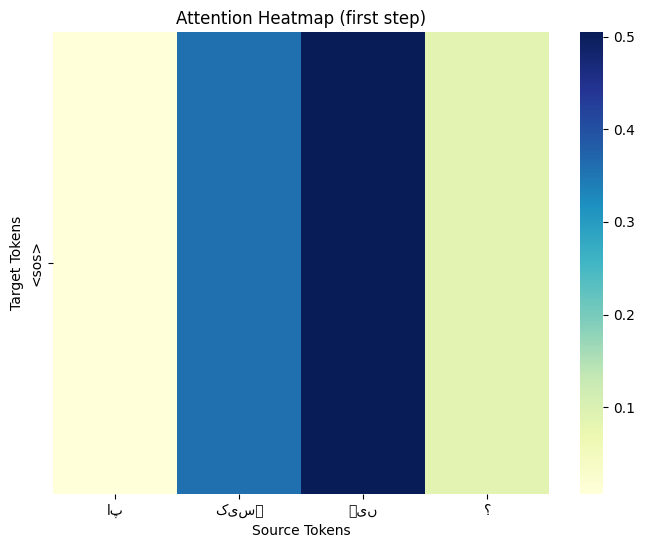

In [95]:
# Cell 13 — visualize attention
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_attention(model, src_text, tgt_vocab):
    src_seq = encode_input(src_text, src_vocab)
    src = src_seq.unsqueeze(0)
    src_mask = model.make_src_mask(src)
    with torch.no_grad():
        memory, _ = model.encoder(src, src_mask)
        ys = torch.tensor([[tgt_vocab.token2idx[SOS]]], device=DEVICE)
        _, attn_maps = model.decoder(ys, memory, model.make_tgt_mask(ys), src_mask)
    attn = attn_maps[-1][0].mean(0).cpu().numpy()  # average heads
    src_tokens = simple_tokenize(normalize_urdu(src_text))
    tgt_tokens = [SOS]  # first token
    plt.figure(figsize=(8,6))
    sns.heatmap(attn[:len(tgt_tokens), :len(src_tokens)], xticklabels=src_tokens,
                yticklabels=tgt_tokens, cmap="YlGnBu")
    plt.xlabel("Source Tokens"); plt.ylabel("Target Tokens")
    plt.title("Attention Heatmap (first step)")
    plt.show()

visualize_attention(model, "آپ کیسے ہیں؟", tgt_vocab)


In [96]:
# Cell 14 — save final model & vocabs
def save_vocab(vocab, path):
    with open(path, "w", encoding="utf-8") as f:
        json.dump({"token2idx": vocab.token2idx, "idx2token": vocab.idx2token}, f, ensure_ascii=False)

save_vocab(src_vocab, os.path.join(MODEL_DIR, "src_vocab.json"))
save_vocab(tgt_vocab, os.path.join(MODEL_DIR, "tgt_vocab.json"))
save_checkpoint(model, optimizer, os.path.join(MODEL_DIR, "final_checkpoint.pt"))
print("✅ Model & vocabs saved in", MODEL_DIR)


✅ Model & vocabs saved in models


In [ ]:
!pip install streamlit pyngrok --quiet
from pyngrok import ngrok
from google.colab import userdata

# Get ngrok authtoken from Colab secrets
NGROK_AUTH_TOKEN = userdata.get('NGROK_AUTH_TOKEN')
if NGROK_AUTH_TOKEN is None:
    print("NGROK_AUTH_TOKEN not found in Colab secrets. Please add it.")
else:
    # Connect your authtoken
    ngrok.set_auth_token(NGROK_AUTH_TOKEN)

      # Get public link
    public_url = ngrok.connect(8501)
    print("🔗 Open your chatbot here:", public_url)

    # Run Streamlit in background
    !streamlit run streamlit_urdu_chatbot.py --server.port 8501 &



🔗 Open your chatbot here: NgrokTunnel: "https://jadon-overgreedy-overthinly.ngrok-free.dev" -> "http://localhost:8501"



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.247.188.148:8501

